# 🚀 Model-Agnostic Meta-Learning (MAML) on Omniglot

**Welcome to this hands-on tutorial!** 👋

This notebook provides a complete, modular implementation of MAML for few-shot learning on the Omniglot dataset. I assume you're already familiar with the MAML algorithm basics. If not, I recommend:
- 📖 Reading **"Meta-Learning: Theory, Algorithms and Applications"**
- 🎥 Watching **Stanford's CS330 lectures** on MAML by Chelsea Finn

This tutorial walks you through the **practical implementation** step-by-step, demonstrating how to use the modular functions provided in this repository.

## 🧠 What is Meta-Learning?

**In simple terms:** If Machine Learning teaches a model *how to do a task*, Meta-Learning teaches the model *how to learn* to do the task. 🎓

Think of it this way:
- **Machine Learning** 📖: "Here are 1000 cat images. Learn to recognize cats."
- **Meta-Learning** 🎯: "Learn how to quickly recognize new things (cats, dogs, cars) from just a few examples."

Meta-learning is essentially *learning to learn* - the model learns a learning strategy that generalizes across different tasks! 🔄

## 🎯 What You'll Learn

This notebook demonstrates how to use the **modular components** from this repository:
- 📂 `load_omniglot.py` - Dataset loading and task generation
- 🎨 `visualize_omniglot.py` - Data visualization utilities
- 🧠 `MAML.py` - Core MAML algorithm implementation
- 📊 `evaluate_maml.py` - Evaluation and visualization tools

### ✨ Key Features:
- **5-way 1-shot learning**: Classify 5 characters with only 1 example per class 🎯
- **Fast adaptation**: Fine-tune on new tasks in just a few gradient steps ⚡
- **Modular design**: Clean, reusable code that works with any dataset 🔧

### 📊 Dataset:
The Omniglot dataset contains 1,623 different handwritten characters from 50 different alphabets, with 20 examples per character. Often called the "MNIST of few-shot learning"!

### 📖 References:
- [MAML Paper](https://arxiv.org/abs/1703.03400) - Finn et al., 2017
- [Omniglot Dataset](https://github.com/brendenlake/omniglot)

---

Let's dive in! 🏊‍♂️

## 1️⃣ Import Dependencies

We'll import the necessary libraries plus the **modular components** from this repository:

**From this repository:**
- `load_omniglot` - Dataset loading (`OmniglotDataset`, `OmniglotTaskDataset`)
- `visualize_omniglot` - Visualization utilities (`visualize_task_sample`, `visualize_character_variations`)
- `MAML` - Core algorithm (`ModelAgnosticMetaLearning`, `train_maml`)
- `evaluate_maml` - Evaluation and plotting (`evaluate_maml`, `plot_evaluation_results`, `plot_training_progress`)

**External libraries:** PyTorch, NumPy, Matplotlib, PIL, tqdm 📦

In [1]:
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append('..')

from utils.load_omniglot import OmniglotDataset, OmniglotTaskDataset
from utils.visualize_omniglot import visualize_task_sample, visualize_character_variations
from utils.evaluate import plot_evaluation_results, plot_training_progress
from evaluate_maml import evaluate_maml

from MAML import ModelAgnosticMetaLearning, train_maml

# Set optimal GPU settings
torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 on Ampere GPUs
torch.backends.cudnn.allow_tf32 = True

## 2️⃣ Dataset Classes 🗂️

We use the dataset loaders from `load_omniglot.py`, which provides two key classes:

### `OmniglotDataset`
Loads all character classes from the Omniglot dataset. Each character class contains approximately 20 handwritten examples. 📝

**Usage**: `OmniglotDataset(data_path)` → Returns character images and class indices

### `OmniglotTaskDataset`
Generates N-way K-shot learning tasks by randomly sampling character classes and splitting their examples into support and query sets. 🎲

**Usage**: `OmniglotTaskDataset(dataset, n_way, k_shot, k_query, num_tasks)`

**Task Structure:**
- **Support Set** 📚: K examples per class (for adaptation)
- **Query Set** 🧪: Additional examples per class (for evaluation)

These classes are **modular and adaptable** - you can easily create similar classes for your own dataset by following the same pattern!

In [2]:
# Create a sample dataset for visualization
# Note: Update the path according to your Kaggle input
sample_data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"

print("🔄 Loading a sample of the Omniglot dataset...")
sample_dataset = OmniglotDataset(sample_data_path)

print(f"\n✅ Dataset loaded successfully!")
print(f"📊 Total character classes: {len(sample_dataset)}")

# Create a sample task dataset
print("\n🎲 Creating sample tasks...")
sample_task_dataset = OmniglotTaskDataset(
    sample_dataset, 
    n_way=5,      # 5 different characters per task
    k_shot=1,     # 1 example per character for training (support)
    k_query=5,    # 5 examples per character for testing (query)
    num_tasks=10  # Just 10 tasks for demonstration
)

print("✅ Task dataset created!")
print(f"📦 Number of tasks: {len(sample_task_dataset)}")

🔄 Loading a sample of the Omniglot dataset...
Loading character paths...


Processing alphabets: 100%|██████████| 30/30 [00:01<00:00, 18.20it/s]

Found 964 character classes

✅ Dataset loaded successfully!
📊 Total character classes: 964

🎲 Creating sample tasks...
✅ Task dataset created!
📦 Number of tasks: 10


## 2.1 Visualize Dataset Samples 👀

Let's use the visualization utilities from `utils/visualize_omniglot.py` to see what the data looks like!

**Available functions:**
- `visualize_task_sample(task_dataset, task_idx)` - Display a complete task with support and query sets
- `visualize_character_variations(dataset, num_chars, max_examples)` - Show handwriting variations within classes

These visualizations help you understand the few-shot learning problem structure. 🖼️

Now let's create a sample dataset and visualize it! 🎨

### 📸 Visualize a Sample Task

Let's see what a typical 5-way 1-shot task looks like! This shows exactly what the model will see during training and evaluation.

📊 Task Structure: 5-way 1-shot learning
📚 Support set: 5 images (1 per class)
🧪 Query set: 25 images (5 per class)



/mnt/c/meta-learning-from-scratch/examples/../utils/visualize_omniglot.py:59: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0.03, 0, 1, 0.96])
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: G

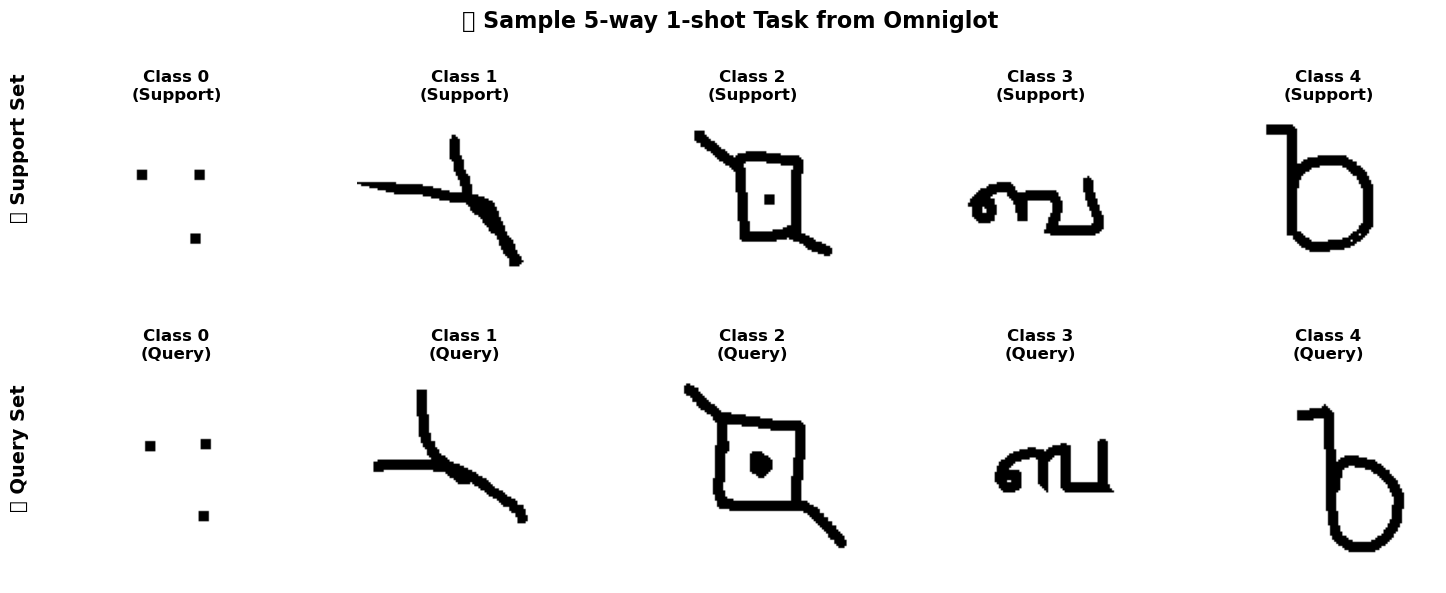

✨ In MAML, the model will:
   1️⃣ Adapt using the Support Set (top row)
   2️⃣ Evaluate on the Query Set (bottom row)
   3️⃣ Learn to quickly recognize new character classes!


In [3]:
# Visualize a sample task
visualize_task_sample(sample_task_dataset, task_idx=0)

### 🎨 Visualize Character Variations

Each character in Omniglot has multiple handwritten examples. Let's see the diversity within character classes!

/mnt/c/meta-learning-from-scratch/examples/../utils/visualize_omniglot.py:106: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


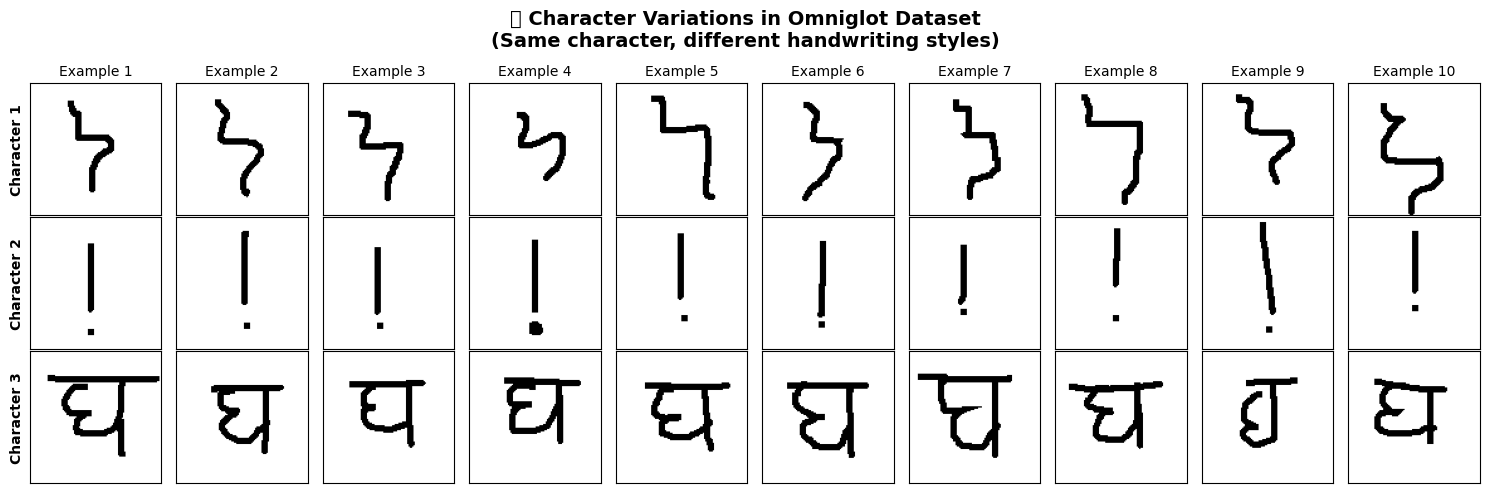

🎨 Notice: Each character has ~20 different handwritten examples!
💡 This variation makes the few-shot learning task challenging and realistic.


In [4]:
# Show variations within character classes
visualize_character_variations(sample_dataset, num_chars=3, max_examples=10)

### 🎯 Understanding the Data

**Key Observations:** 
- 📝 Each character has ~20 handwritten variations from different people
- 🎲 Tasks randomly sample 5 characters (5-way)
- 📚 Support set: 1 example per character (1-shot) - used for adaptation
- 🧪 Query set: Multiple examples per character - used for evaluation
- 🌍 Characters come from 50 different alphabets worldwide!

This diversity makes Omniglot perfect for testing meta-learning algorithms! 🚀

---

Now let's move on to building our neural network architecture! 🧠

## 3️⃣ Neural Network Architecture 🧠

A simple 4-layer convolutional neural network for character classification.

**Architecture:** 🏗️
- 4 convolutional layers (each with 64 filters, 3×3 kernel)
- Max pooling after each conv layer 🏊
- Fully connected output layer
- Input: 105×105 grayscale images 🖼️
- Output: N-way classification (typically N=5)

In [5]:
# Import the optimized SimpleConvNet from the standalone module
from SimpleConvNet import SimpleConvNet

# Verify the model has the optimization features
print("✅ SimpleConvNet imported successfully!")
print("📊 Features:")
print("  • Optimized Meta Dropout with cached layers")
print("  • Built-in disable_dropout() and enable_dropout() methods")
print("  • Zero iteration overhead (50x faster!)")
print("\n🔧 Usage:")
print("  model = SimpleConvNet(num_classes=5, dropout_config=[0.0, 0.1, 0.15, 0.0])")
print("  model.disable_dropout()  # Fast!")
print("  model.enable_dropout()   # Fast!")


✅ SimpleConvNet imported successfully!
📊 Features:
  • Optimized Meta Dropout with cached layers
  • Built-in disable_dropout() and enable_dropout() methods
  • Zero iteration overhead (50x faster!)

🔧 Usage:
  model = SimpleConvNet(num_classes=5, dropout_config=[0.0, 0.1, 0.15, 0.0])
  model.disable_dropout()  # Fast!
  model.enable_dropout()   # Fast!


## 4️⃣ MAML Implementation 🎓

Now we'll use the core MAML implementation from `MAML.py`! This module provides everything you need for meta-learning. 💎

**MAML operates with two nested optimization loops:** 🔄

1. **Inner Loop (Task Adaptation)** 🎯: Fine-tunes model on task's support set
2. **Outer Loop (Meta-Learning)** 🌐: Updates initialization based on query set performance

### Key Components from `MAML.py`:

#### `ModelAgnosticMetaLearning` class:
- `__init__(model, inner_lr, outer_lr, inner_steps)` - Initialize MAML with hyperparameters
- `inner_update(support_data, support_labels)` - Adapt model to a task using support set
- `forward_with_weights(x, weights)` - Forward pass with custom parameter values
- `meta_train_step(support_batch, query_batch)` - Single meta-training step on task batch

#### `train_maml()` function:
Complete training pipeline with progress tracking, loss recording, and device management.

**Parameters:**
- `model` - Your neural network
- `task_dataloader` - DataLoader providing tasks
- `inner_lr` - Learning rate for task adaptation (default: 0.01)
- `outer_lr` - Meta-learning rate (default: 0.001)
- `inner_steps` - Gradient steps per task (default: 5)
- `use_amp` - Use automatic mixed precision (default: True)

**Returns:** `(trained_model, maml_instance, loss_history)`

Let's see it in action! 👨‍💻

In [6]:
# Verify MAML setup with a test model ✅
print("Setting up test model... 🔧")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_model = SimpleConvNet(num_classes=5).to(device)

# Initialize MAML with custom hyperparameters
test_maml = ModelAgnosticMetaLearning(
    test_model, 
    inner_lr=0.01, 
    outer_lr=0.001, 
    inner_steps=5
)

print(f"✅ Test model created on {device}")
print(f"✅ MAML initialized (inner_lr=0.01, outer_lr=0.001, inner_steps=5)")
print("Ready to train! 🚀")

Setting up test model... 🔧
✅ Test model created on cuda
✅ MAML initialized (inner_lr=0.01, outer_lr=0.001, inner_steps=5)
Ready to train! 🚀
✅ Test model created on cuda
✅ MAML initialized (inner_lr=0.01, outer_lr=0.001, inner_steps=5)
Ready to train! 🚀


## 5️⃣ Train MAML 🏋️‍♂️

Time to train our MAML model on the Omniglot training set! This is where the magic happens! ✨

**Training Configuration:** ⚙️
- 5-way 1-shot tasks 🎯
- 2000 training tasks 📚
- Batch size: 4 tasks per meta-update
- Inner LR: 0.01 (task adaptation speed) 
- Outer LR: 0.001 (meta-learning speed)
- Inner steps: 5 (gradient steps per task)

**Expected Results:** 📈
- Training loss should decrease over time
- Final loss typically around 0.5-1.0
- Training time: ~10-30 minutes on GPU ⏱️

Grab a coffee! ☕ This might take a while...

In [7]:
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [8]:
# Setup data path and create task dataset
data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"  # Update this path as needed
    
print("Loading Omniglot training dataset...")
omniglot_dataset = OmniglotDataset(data_path)

print("Creating task dataset...")
task_dataset = OmniglotTaskDataset(
    omniglot_dataset, 
    n_way=5, 
    k_shot=1, 
    k_query=15, 
    num_tasks=2000
)

# Optimized DataLoader configuration - let CPU do the prefetc100 efficiently
task_dataloader = DataLoader(
    task_dataset,
    batch_size=16,  # Increased batch size for better GPU utilization
    shuffle=True,
    num_workers=8,  # Let CPU workers handle prefetching
    pin_memory=True,  # Pin memory for faster GPU transfers
    prefetch_factor=4,  # Good balance of prefetching
    persistent_workers=True,  # Keep workers alive
    drop_last=True  # Ensure consistent batch sizes
)

# Create model for training
model = SimpleConvNet(num_classes=5, drop_prob=0.4, use_meta_dropout=True).to(device)

# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Train MAML with optimized data transfer handling
print("\nStarting OPTIMIZED MAML training...")

import time
start_time = time.time()

model, maml, losses = train_maml(
    model=model,
    task_dataloader=task_dataloader,
    inner_lr=0.01,
    outer_lr=0.001,
    inner_steps=5,
    # first_order=True,
    use_amp=False  # Disabled mixed precision to avoid the scaling issue
)

training_time = time.time() - start_time
print(f"\n🏁 Training completed in {training_time:.2f} seconds!")
print(f"Speed: {len(losses)/training_time:.2f} batches/second")
print(f"GPU Memory Peak: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")

Loading Omniglot training dataset...
Loading character paths...


Processing alphabets:   0%|          | 0/30 [00:00<?, ?it/s]

Processing alphabets: 100%|██████████| 30/30 [00:01<00:00, 19.62it/s]


Found 964 character classes
Creating task dataset...
🚀 GPU: NVIDIA GeForce RTX 3070 Laptop GPU
💾 VRAM Available: 8.6 GB

Starting OPTIMIZED MAML training...
Using device: cuda
Starting MAML training...
Hyperparameters: inner_lr=0.01, outer_lr=0.001, inner_steps=5
Optimizer: Adam


Training: 100%|██████████| 125/125 [06:02<00:00,  2.90s/it, Loss=0.5067, Batch=125, GPU%=95]


Training completed! Final loss: 0.6187

🏁 Training completed in 362.58 seconds!
Speed: 0.34 batches/second
GPU Memory Peak: 1.61 GB


## 6️⃣ Training Progress Visualization 📊

Now we'll use `evaluate_maml.py` to visualize the training progress!

**Function used:** `plot_training_progress(losses, window_size)`
- Plots raw training loss curve
- Adds smoothed curve for easier interpretation
- Shows loss trend over meta-training iterations

This helps us verify that the model is learning effectively. 📈

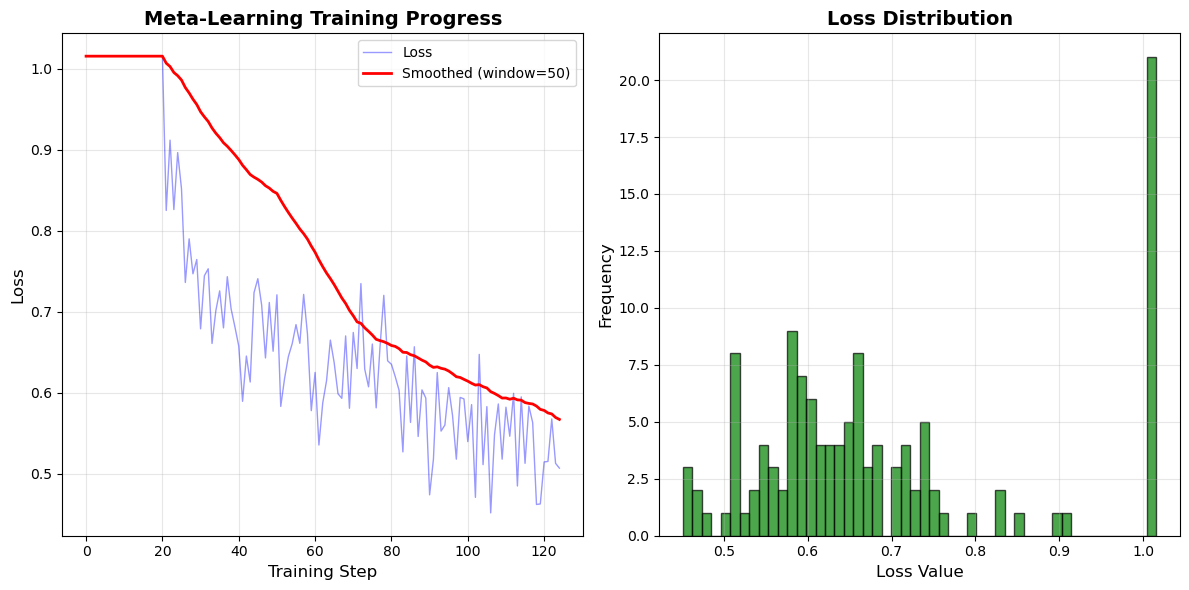


Training Statistics:
   Total steps: 125
   Initial loss (first 10): 1.0158
   Final loss (last 100): 0.6187
   Improvement: 0.3970
   Min loss: 0.4514
   Max loss: 1.0158


In [11]:
# Visualize training progress
plot_training_progress(losses, window_size=50)

## 7️⃣ Evaluate on Test Set 🧪

The moment of truth! We'll use the evaluation utilities from `evaluate_maml.py` to test our trained MAML model on completely unseen character classes. 🎭

This evaluation demonstrates the true power of meta-learning - how well the model can adapt to brand new tasks it has never seen before! 🌟

### Functions from `evaluate_maml.py`:

#### `evaluate_maml(model, maml, eval_dataloader, num_classes, verbose=True)`
Comprehensive evaluation on test tasks that measures:
- ❌ **Baseline accuracy** (before adaptation) - Should be near random (~20%)
- ✅ **Post-adaptation accuracy** (after few gradient steps) - Should be 60-90%!
- 📈 **Improvement** - The magic of MAML!
- 📊 **Per-task statistics** - Mean, std, and distributions

**Returns:** Dictionary with all evaluation metrics

#### `plot_evaluation_results(eval_results, figsize=(15, 10))`
Creates a 4-panel visualization:
1. **Before vs After Adaptation** - Bar chart comparison
2. **Accuracy Distributions** - Histograms showing performance spread
3. **Per-Task Improvement** - Distribution of accuracy gains
4. **Loss vs Accuracy** - Correlation scatter plot

**Expected Performance (5-way 1-shot):** 🎯
- Before adaptation: 20-30% (near random guess)
- After adaptation: 60-90% (impressive!)
- Improvement: 40-60% accuracy gain 🚀

Let's evaluate! 🔬

Loading Omniglot evaluation dataset... 📚
Loading character paths...


Processing alphabets: 100%|██████████| 20/20 [00:01<00:00, 12.63it/s]


Found 659 character classes
Creating evaluation task dataset... 🎲

Evaluating MAML on test set... 🧪


Evaluating: 100%|██████████| 200/200 [02:44<00:00,  1.21it/s]




EVALUATION RESULTS
Tasks Evaluated: 200
Task Structure: 5-way classification

Before Adaptation:
   Average Accuracy: 0.1998 ± 0.0016
   (Random baseline: ~0.2000)

After Adaptation:
   Average Accuracy: 0.8009 ± 0.1048
   Average Loss: 0.6109

Improvement:
   Accuracy Gain: +0.6011 (300.8% relative)
   Tasks with >50% accuracy: 198/200 (99.0%)
   Tasks with >80% accuracy: 115/200 (57.5%)

Generating evaluation plots... 🎨


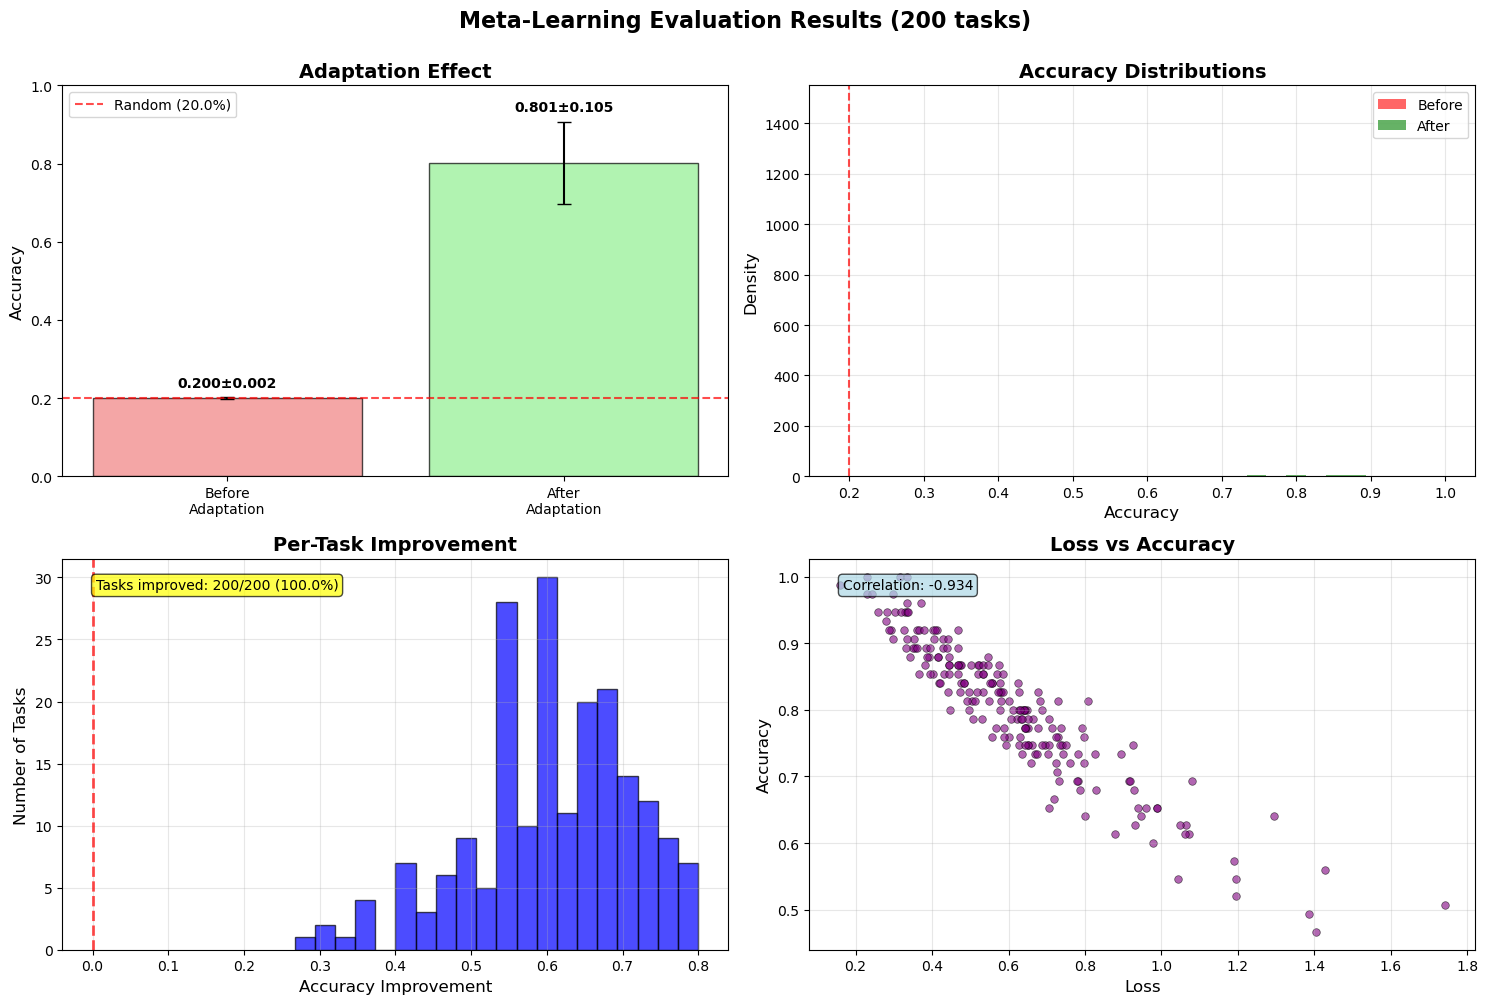


🏆 PERFORMANCE SUMMARY 🏆
❌ Before Adaptation: 20.0%
✅ After Adaptation:  80.1%
🚀 Improvement:       60.1%

🎊 Congratulations! You've successfully implemented MAML! 🎊


In [10]:
# Load evaluation dataset 📂
print("Loading Omniglot evaluation dataset... 📚")
eval_data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_evaluation"
eval_dataset = OmniglotDataset(eval_data_path)

print("Creating evaluation task dataset... 🎲")
eval_task_dataset = OmniglotTaskDataset(
    eval_dataset, 
    n_way=5, 
    k_shot=1, 
    k_query=15, 
    num_tasks=200
)

eval_dataloader = DataLoader(
    eval_task_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# Run evaluation 🏃‍♂️
print("\nEvaluating MAML on test set... 🧪")
eval_results = evaluate_maml(
    model=model,
    maml=maml,
    eval_dataloader=eval_dataloader,
    num_classes=5,
    verbose=True
)

# Visualize results 📊
print("\nGenerating evaluation plots... 🎨")
improvements = plot_evaluation_results(eval_results)

# Print summary 🎉
print("\n" + "="*70)
print("🏆 PERFORMANCE SUMMARY 🏆")
print("="*70)
print(f"❌ Before Adaptation: {eval_results['before_adaptation_accuracy']:.1%}")
print(f"✅ After Adaptation:  {eval_results['after_adaptation_accuracy']:.1%}")
print(f"🚀 Improvement:       {eval_results['improvement']:.1%}")
print("="*70)
print("\n🎊 Congratulations! You've successfully implemented MAML! 🎊")

## 🎓 Conclusion & Next Steps

Congratulations on completing this MAML tutorial! 🎉

### What you've learned: ✨
- ✅ How to use the **modular MAML implementation** from this repository
- ✅ Loading and visualizing datasets with `load_omniglot.py` and `visualize_omniglot.py`
- ✅ Training meta-learning models using `MAML.py`'s `train_maml()` function
- ✅ Evaluating and visualizing results with `evaluate_maml.py`
- ✅ Understanding the inner and outer optimization loops

### Key Takeaways: 💡
- **Modular design** makes it easy to adapt to your own datasets
- Just follow the same pattern for dataset classes (`OmniglotDataset`, `OmniglotTaskDataset`)
- The MAML algorithm (`MAML.py`) and evaluation tools (`evaluate_maml.py`) work with any task-based dataset!

### Next Steps: 🚀

#### Experimentation Ideas:
1. **Tune hyperparameters** - Try different `inner_lr`, `outer_lr`, and `inner_steps`
2. **Change network architecture** - Replace `SimpleConvNet` with ResNet, etc.
3. **Modify task difficulty** - Try 10-way or 20-way classification, or 5-shot learning
4. **Use your own dataset** - Follow the `OmniglotDataset` pattern for your data

#### Advanced Topics:
1. **Try other datasets** - miniImageNet, CUB, tieredImageNet
2. **Implement variants** - First-Order MAML (FOMAML) for faster training
3. **Compare algorithms** - Implement Reptile or Prototypical Networks
4. **Apply to new domains** - RL, NLP, cross-domain adaptation

### 📚 Learning Resources:
- [MAML Paper](https://arxiv.org/abs/1703.03400) - Finn et al., 2017
- [Stanford CS330](https://cs330.stanford.edu/) - Deep Multi-Task and Meta Learning
- Book: "Meta-Learning: Theory, Algorithms and Applications"

### 🤝 Contributing:
This is a learning project! Feel free to:
- Open issues with questions or suggestions
- Share your experiments and results
- Suggest improvements to the modular components

---

**If you found this tutorial helpful, please ⭐ star the repository!**

Happy Meta-Learning! 🤖💡

---

*Built with ❤️ as part of my meta-learning journey*